In [ ]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
from scipy.integrate import cumulative_trapezoid
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter
import time

# --- Physical Constants ---
g = constants.g
cpd = 1005.7
Rd = 287.05
Rv = 461.5
epsilon = Rd / Rv
P0 = 100000.0
Lv = 2.501e6

# --- Thermodynamic Functions ---
def saturation_vapor_pressure(T):
    T_celsius = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_celsius)/(T_celsius + 243.5))
    return es_hPa * 100.0 # Pa

def saturation_specific_humidity(p, T):
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    denom = p - (1.0 - epsilon) * es
    qs = np.divide(epsilon * es, denom, out=np.full_like(p,1e-9), where=denom>0)
    return np.maximum(qs,1e-9)

def dqs_dT(p, T, dT=0.01):
    return (saturation_specific_humidity(p, T + dT)
          - saturation_specific_humidity(p, T - dT)) / (2*dT)

def dqs_dp(p, T, dp=10.0):
    return (saturation_specific_humidity(p + dp, T)
          - saturation_specific_humidity(p - dp, T)) / (2*dp)

def d2qs_dT2(p, T, dT=0.01):
    qs_p = saturation_specific_humidity(p, T + dT)
    qs_0 = saturation_specific_humidity(p, T)
    qs_m = saturation_specific_humidity(p, T - dT)
    return (qs_p - 2*qs_0 + qs_m) / (dT**2)

def d2qs_dTdp(p, T, dT=0.01, dp=10.0):
    dT_plus = dqs_dT(p + dp, T, dT)
    dT_minus = dqs_dT(p - dp, T, dT)
    return (dT_plus - dT_minus) / (2*dp)

def virtual_temperature(T, p):
    qs = saturation_specific_humidity(p, T)
    Tv = T * (1 + (1/epsilon - 1)*qs)
    return np.maximum(Tv,10.0)

def calculate_mse(T, p, z):
    qs = saturation_specific_humidity(p, T)
    return cpd * T + g * z + Lv * qs

def calculate_profile_with_rootfinder(T_surf, p_surf, p_grid):
    n = len(p_grid)
    T_prof = np.full(n, np.nan)
    z_prof = np.full(n, np.nan)
    T_prof[0], z_prof[0] = T_surf, 0.0
    mse0 = calculate_mse(T_surf, p_grid[0], 0.0)

    for i in range(n-1):
        T_cur, p_cur, z_cur = T_prof[i], p_grid[i], z_prof[i]
        p_next = p_grid[i+1]
        
        if np.isnan(T_cur) or p_cur <= 0:
            break
        Tv = virtual_temperature(T_cur, p_cur)
        dz = - (Rd * Tv / p_cur) / g * (p_next - p_cur)
        z_next = z_cur + dz
        
        def resid(Tg):
            return calculate_mse(Tg, p_next, z_next) - mse0
        
        try:
            br = [150.0, T_cur]
            if resid(br[0]) * resid(br[1]) > 0:
                break
            sol = root_scalar(resid, bracket=br, method='brentq', xtol=1e-3)
            if sol.converged:
                T_prof[i+1], z_prof[i+1] = sol.root, z_next
            else:
                break
        except (ValueError, RuntimeError):
            break
    return T_prof

print("--- Starting Main Calculation ---")
start_time = time.time()

# --- Grid setup ---
# Compute on expanded Ts domain to avoid left-edge artifacts
T_surf_values = np.arange(279, 320.1, 1.0) # expanded
Tmin_plot = 280.0 # visible lower bound
plot_mask = T_surf_values >= Tmin_plot # columns to display
p_surf_pa, p_top, dp = 100000.0, 10000.0, -50.0
p_grid = np.arange(p_surf_pa, p_top + dp, dp)
n_p, n_t = len(p_grid), len(T_surf_values)
A_grid = np.full((n_p, n_t), np.nan)
B_grid = np.full((n_p, n_t), np.nan)

for j, Ts in enumerate(T_surf_values):
    print(f"Processing Ts = {Ts:.1f} K...")
    Tprof = calculate_profile_with_rootfinder(Ts, p_surf_pa, p_grid)

    if np.isnan(Tprof[-1]):
        print(f" -> Failed to generate complete profiles for Ts = {Ts:.1f} K.")
        continue

    # thermodynamics
    alpha_d = Rd * Tprof / p_grid
    cL = Lv * dqs_dT(p_grid, Tprof)
    alpha_L = Lv * dqs_dp(p_grid, Tprof)
    dal_dT = Lv * d2qs_dTdp(p_grid, Tprof)
    dcL_dT = Lv * d2qs_dT2(p_grid, Tprof)
    N = alpha_d - alpha_L
    D = cpd + cL
    dN = (Rd/p_grid) - dal_dT
    dD = dcL_dT
    A_loc = (1.0/D)*dN
    B_loc = - (N/(D**2))*dD
    A_grid[:, j] = A_loc
    B_grid[:, j] = B_loc

print(f"\n--- Calculation Finished in {time.time() - start_time:.2f} seconds ---\n")

--- Starting Main Calculation ---
Processing Ts = 279.0 K...
Processing Ts = 280.0 K...
Processing Ts = 281.0 K...
Processing Ts = 282.0 K...
Processing Ts = 283.0 K...
Processing Ts = 284.0 K...
Processing Ts = 285.0 K...
Processing Ts = 286.0 K...
Processing Ts = 287.0 K...
Processing Ts = 288.0 K...
Processing Ts = 289.0 K...
Processing Ts = 290.0 K...
Processing Ts = 291.0 K...
Processing Ts = 292.0 K...
Processing Ts = 293.0 K...
Processing Ts = 294.0 K...
Processing Ts = 295.0 K...
Processing Ts = 296.0 K...
Processing Ts = 297.0 K...
Processing Ts = 298.0 K...
Processing Ts = 299.0 K...
Processing Ts = 300.0 K...
Processing Ts = 301.0 K...
Processing Ts = 302.0 K...
Processing Ts = 303.0 K...
Processing Ts = 304.0 K...
Processing Ts = 305.0 K...
Processing Ts = 306.0 K...
Processing Ts = 307.0 K...
Processing Ts = 308.0 K...
Processing Ts = 309.0 K...
Processing Ts = 310.0 K...
Processing Ts = 311.0 K...
Processing Ts = 312.0 K...
Processing Ts = 313.0 K...
Processing Ts = 314.0

--- Generating Figure 3 ---


/var/folders/1p/qh999ffj1s16918rzwp10h4h0000gn/T/ipykernel_32301/11479215.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


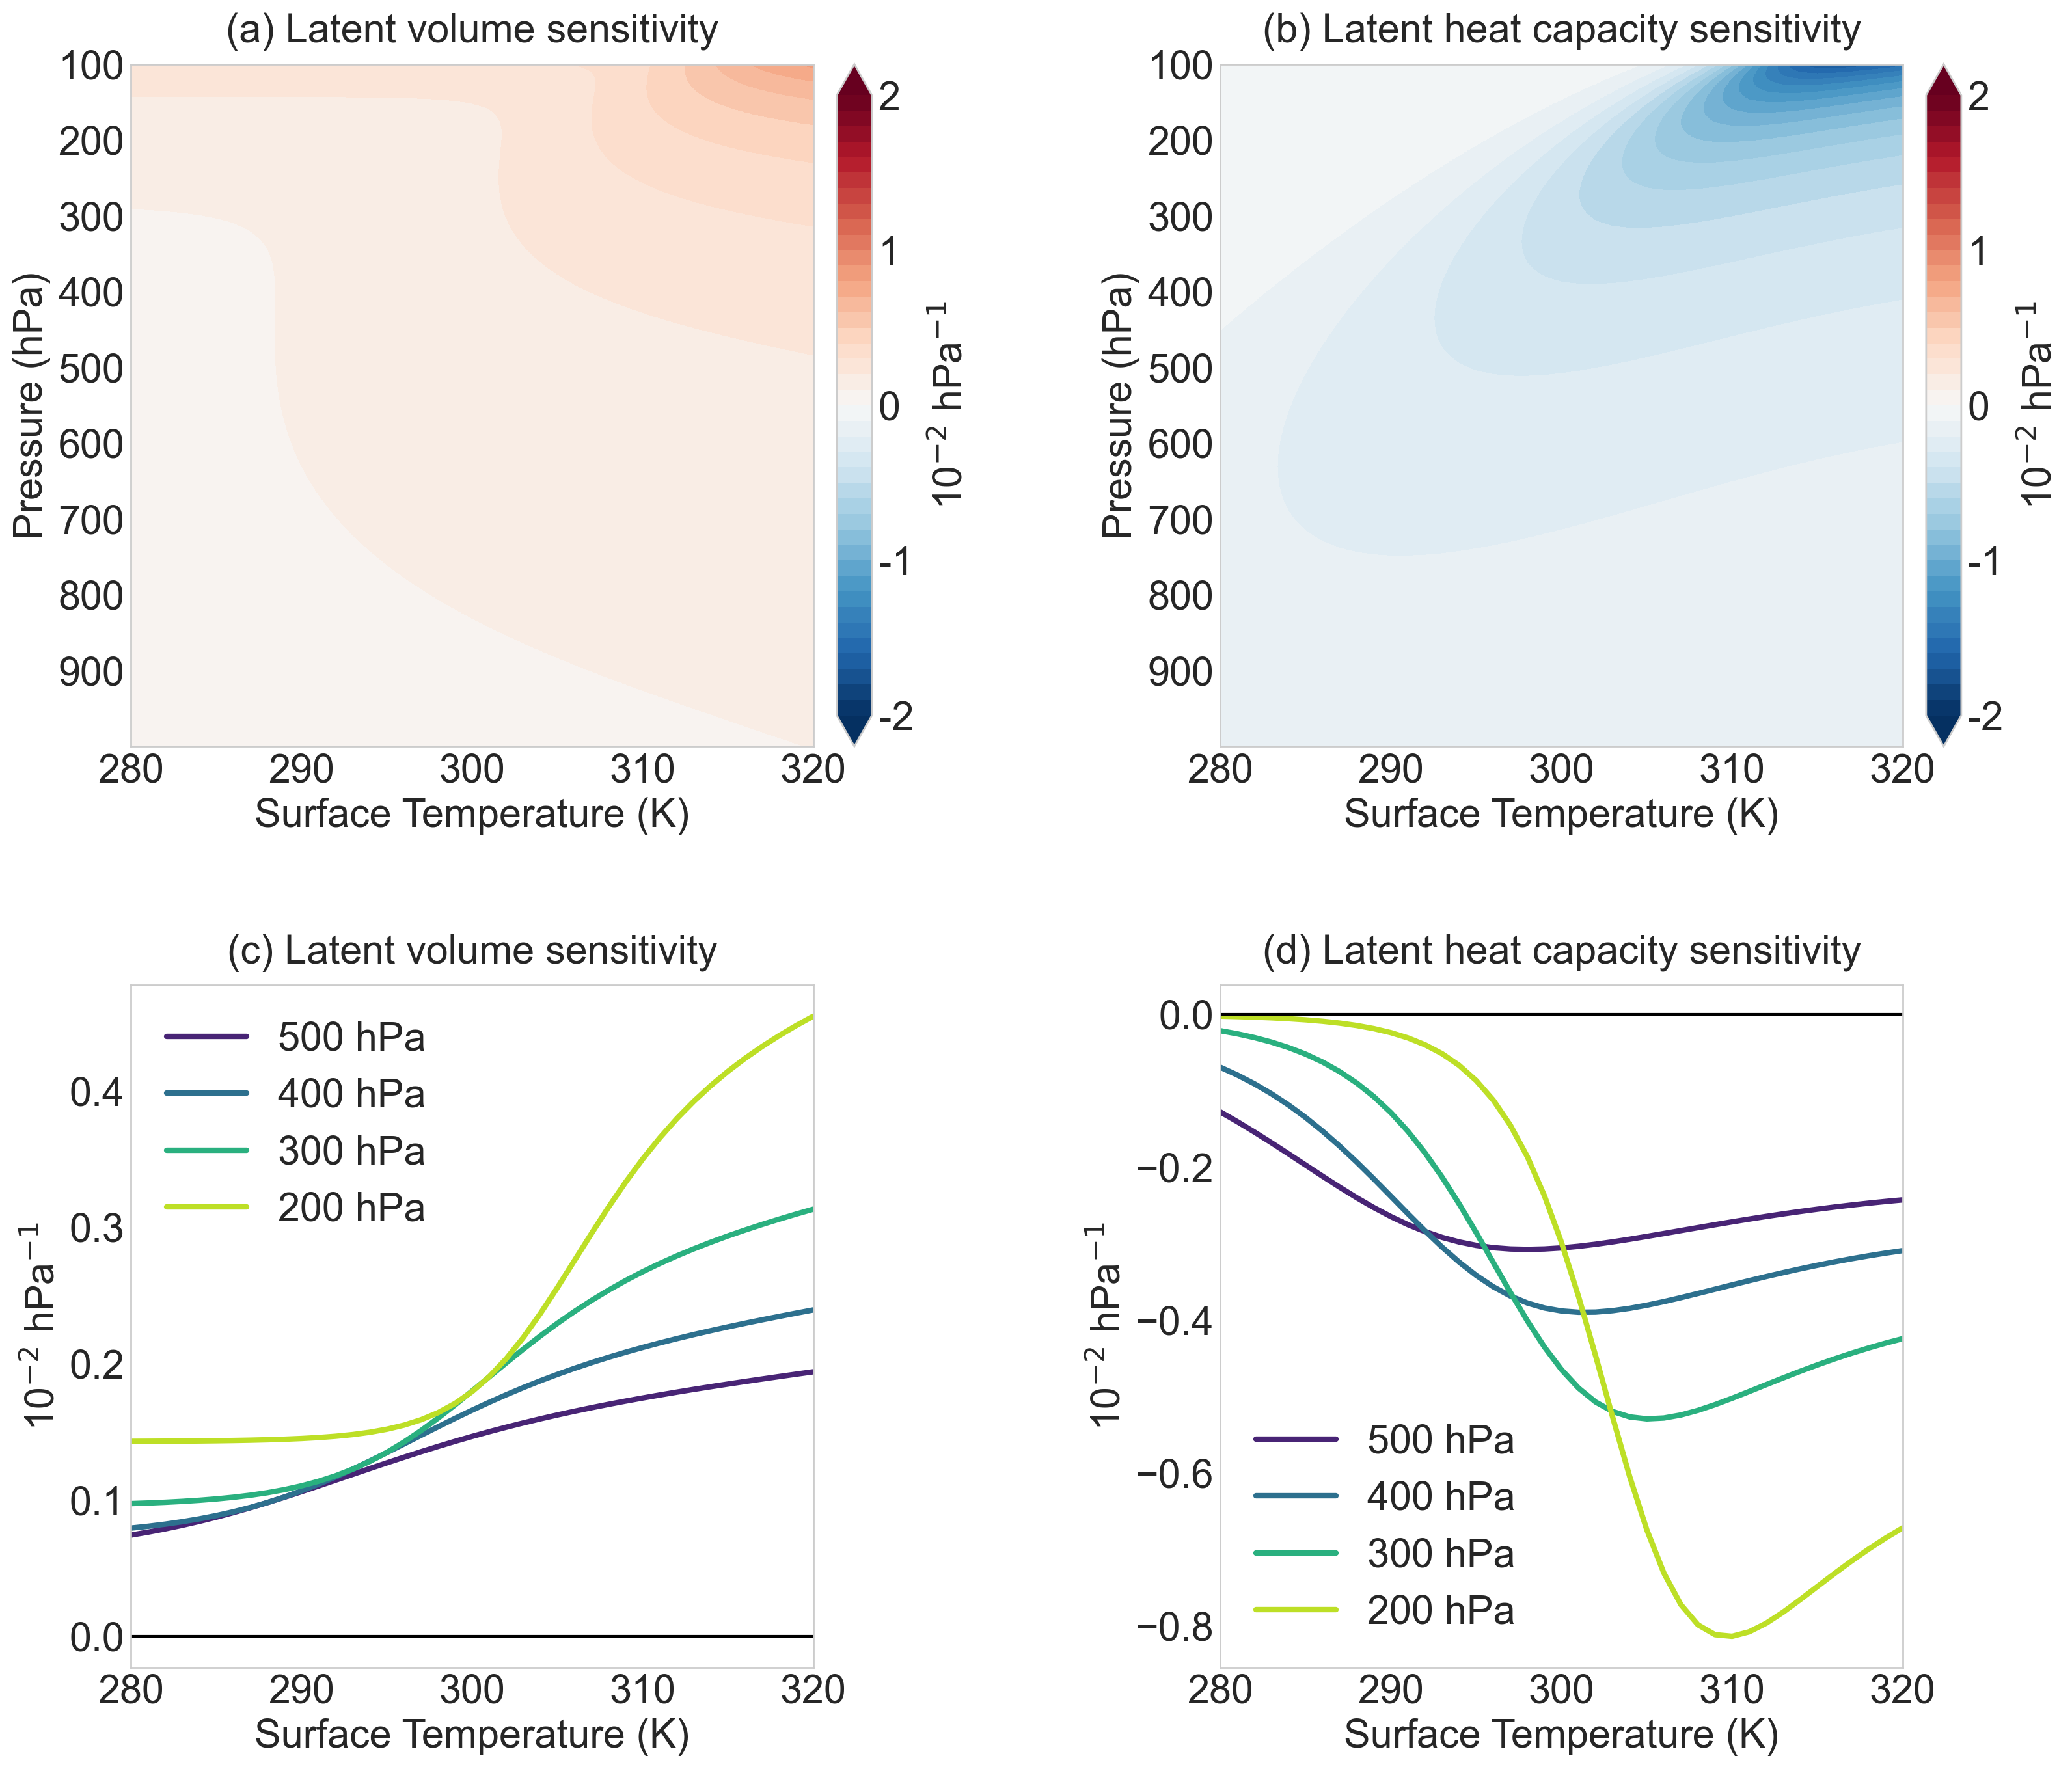

Figure 3 saved as fig-3.png

Script finished.


In [ ]:
# ------------- PLOTTING (use only Ts ≥ 280 K) ----------------
print("--- Generating Figure 3 ---")
plt.style.use('seaborn-v0_8-whitegrid')
base_fontsize = 22
plt.rcParams.update({
    'font.size': base_fontsize,
    'axes.titlesize': base_fontsize,
    'axes.labelsize': base_fontsize,
    'xtick.labelsize': base_fontsize,
    'ytick.labelsize': base_fontsize,
    'legend.fontsize': base_fontsize,
    'figure.titlesize': base_fontsize + 2
})
p_hpa = p_grid / 100.0

# Slice fields to the visible range
T_plot = T_surf_values[plot_mask]
A_plot = A_grid[:, plot_mask]
B_plot = B_grid[:, plot_mask]
Tmat, Pmat = np.meshgrid(T_plot, p_hpa)

# --- Get indices for line plots ---
p_levels_hpa = np.array([500, 400, 300, 200])
p_indices = [np.where(p_hpa == p)[0][0] for p in p_levels_hpa]
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(p_levels_hpa)))

# --- Contour plot settings ---
scale = 1e4
limits = 2
levels_loc= np.arange(-limits, limits+0.1, 0.1)
cmap_loc = plt.get_cmap('RdBu_r')

# --- Figure & Gridspec (2 rows, 2 columns) ---
fig = plt.figure(figsize=(18, 16))
gs = GridSpec(2, 2, wspace=0.5, hspace=0.35)
axs = {
    'a': fig.add_subplot(gs[0, 0]),
    'b': fig.add_subplot(gs[0, 1]),
    'c': fig.add_subplot(gs[1, 0]),
    'd': fig.add_subplot(gs[1, 1]),
}

# Set aspect ratio for contour plots
axs['a'].set_box_aspect(1)
axs['b'].set_box_aspect(1)

# Line plots can have a different aspect
axs['c'].set_box_aspect(1)
axs['d'].set_box_aspect(1)

def draw(ax, Z, levels, cmap, title, label):
    cf = ax.contourf(Tmat, Pmat, Z, levels=levels, cmap=cmap, extend='both')
    ax.set_title(title, pad=12)
    ax.set_ylabel('Pressure (hPa)')
    ax.invert_yaxis()
    ax.set_ylim(1000,100)
    ax.set_yticks(np.arange(100, 1000, 100))
    ax.set_xlabel('Surface Temperature (K)')
    return cf

# --- Draw Panels (a) and (b) ---
contours = {}
contours['a'] = draw(axs['a'], A_plot*scale, levels_loc, cmap_loc,
                   '(a) Latent volume sensitivity',
                   '10$^{-2}$ hPa$^{-1}$')
contours['b'] = draw(axs['b'], B_plot*scale, levels_loc, cmap_loc,
                   '(b) Latent heat capacity sensitivity',
                   '10$^{-2}$ hPa$^{-1}$')

# --- Draw Panels (c) and (d) ---
ax_c = axs['c']
ax_d = axs['d']
for i, p_idx in enumerate(p_indices):
    label = f'{p_levels_hpa[i]:.0f} hPa'
   
    # Panel (c): Term A
    ax_c.plot(T_plot, A_plot[p_idx, :] * scale, label=label, color=colors[i], lw=3)
   
    # Panel (d): Term B
    ax_d.plot(T_plot, B_plot[p_idx, :] * scale, label=label, color=colors[i], lw=3)

# Format Panel (c)
ax_c.set_title('(c) Latent volume sensitivity', pad=12)
ax_c.set_xlabel('Surface Temperature (K)')
ax_c.set_ylabel('10$^{-2}$ hPa$^{-1}$')
ax_c.legend(loc='upper left')
ax_c.grid(False)
ax_c.axhline(0, color='k', ls='-', lw=1.5)
ax_c.set_xlim(T_plot[0], T_plot[-1])

# Format Panel (d)
ax_d.set_title('(d) Latent heat capacity sensitivity', pad=12)
ax_d.set_xlabel('Surface Temperature (K)')
ax_d.set_ylabel('10$^{-2}$ hPa$^{-1}$')
ax_d.legend(loc='lower left')
ax_d.grid(False)
ax_d.axhline(0, color='k', ls='-', lw=1.5)
ax_d.set_xlim(T_plot[0], T_plot[-1])

# Tight layout before placing cbar axes
plt.tight_layout()
fig.canvas.draw()

# --- Colorbars for (a) and (b) ---
cbar_width = 0.015
cbar_pad = 0.01
# Only apply to the contour plots
for key in ['a','b']:
    ax = axs[key]
    pos = ax.get_position()
    cax = fig.add_axes([pos.x1 + cbar_pad, pos.y0, cbar_width, pos.height])
    cbar = fig.colorbar(contours[key], cax=cax, orientation='vertical')
    cbar.set_ticks([-2,-1,0,1,2])
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    cbar.set_label('10$^{-2}$ hPa$^{-1}$', labelpad=10)

fig3_filename = "fig-3.png"
plt.savefig(fig3_filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure 3 saved as {fig3_filename}")
print("\nScript finished.")
